## 1. Load Dataset

In [1]:
import zipfile
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
import cv2

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
PATH = '/content/drive/MyDrive/CUAI/2021_여름프로젝트/'
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 64
EPOCHS = 10
IMAGE_SIZE = 224
IMAGE_PATH = '/content/data/data_front'

In [3]:
# extract data from zipfile
os.makedirs('data', exist_ok=True)

my_zip = zipfile.ZipFile(PATH + 'fin_data/data_front.zip')
my_zip.extractall('data')
my_zip.close()

In [4]:
# load labeled data
labels_df = pd.read_csv(PATH + 'fin_data/t_result.csv')
labels_df['name_class'] = labels_df['fname'].apply(lambda x: 0 if x[:2] == 'HY' else (1 if x[:2] == 'JM' else (2 if x[:2] == 'YS' else 3)))

X = labels_df.drop('labels', axis=1)
y = labels_df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['name_class'], test_size=0.1, random_state=seed)
X_train['name_class'].value_counts()

3    900
1    900
2    900
0    900
Name: name_class, dtype: int64

In [5]:
# image transform
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize([IMAGE_SIZE, IMAGE_SIZE])])

# custom datasets
class FrontDataset(Dataset):
  def __init__(self, X_df, y, image_path, transform=None):
    self.X_data = X_df
    self.label = y
    self.path = image_path
    self.transform = transform

  def __len__(self):
    return len(self.X_data)

  def __getitem__(self, idx):
    image = cv2.imread(os.path.join(self.path, self.X_data.iloc[idx, 0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = self.transform(image)
    label = self.label.iloc[idx]
    return image, label

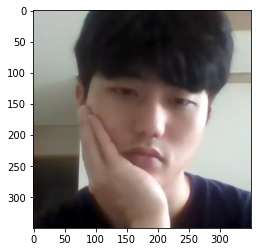

In [6]:
# front image example
t = cv2.imread(os.path.join(IMAGE_PATH, X_train.iloc[0, 0]))
t = cv2.cvtColor(t, cv2.COLOR_BGR2RGB)
plt.imshow(t)

In [7]:
# train, test datasets
train_data = FrontDataset(X_train, y_train, IMAGE_PATH, transform)
test_data = FrontDataset(X_test, y_test, IMAGE_PATH, transform)

# train, test dataloader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 2. Modeling: GoogLeNet

In [8]:
googlenet = models.googlenet(pretrained=True)
for params in googlenet.parameters():
  params.requires_grad == True
# googlenet.fc.in_features == 1024
googlenet.fc = nn.Linear(1024, 1)
googlenet = googlenet.to(DEVICE)

optimizer = torch.optim.Adam(googlenet.parameters(), lr=0.001)
criterion = nn.BCELoss()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [9]:
def train(model, dataloader, optimizer, log_interval=20):
  model.train()
  train_epoch_loss = 0.0

  for batch_idx, (image, label) in enumerate(dataloader):
    image = image.to(DEVICE)
    label = label.to(DEVICE).float()
    optimizer.zero_grad()
    output = torch.sigmoid(model(image).squeeze())
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    train_epoch_loss += loss.item()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch+1, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
    train_epoch_loss /= (len(dataloader.dataset) / BATCH_SIZE)
  return train_epoch_loss

In [10]:
def validate(model, dataloader):
  model.eval()
  valid_epoch_loss = 0.0
  correct_results_sum = 0

  with torch.no_grad():
    for image, label in dataloader:
      image = image.to(DEVICE)
      label = label.to(DEVICE).float()
      output = torch.sigmoid(model(image).squeeze())
      loss = criterion(output, label)
      valid_epoch_loss += loss.item()
      prediction = torch.round(output)
      correct_results_sum += (prediction == label).sum().float().item()
      
  valid_epoch_loss /= (len(dataloader.dataset) / BATCH_SIZE)
  acc_score = correct_results_sum/len(dataloader.dataset) * 100
  return valid_epoch_loss, acc_score

In [11]:
train_loss = []
val_loss = []
acc = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = train(googlenet, train_loader, optimizer, log_interval=20)
    val_epoch_loss, acc_score = validate(googlenet, test_loader)
    acc.append(acc_score)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print("\n[EPOCH: {}]\tTest Loss: {:.4f}\tTest Acc: {:.2f}%\n".format(epoch, val_epoch_loss, acc_score))

Epoch 1 of 10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/3600 (0%)]	Train Loss: 0.691289
Train Epoch: 1 [1280/3600 (35%)]	Train Loss: 0.533602
Train Epoch: 1 [2560/3600 (70%)]	Train Loss: 0.233236

[EPOCH: 0]	Test Loss: 0.3119	Test Acc: 88.50%

Epoch 2 of 10
Train Epoch: 2 [0/3600 (0%)]	Train Loss: 0.179048
Train Epoch: 2 [1280/3600 (35%)]	Train Loss: 0.221623
Train Epoch: 2 [2560/3600 (70%)]	Train Loss: 0.269997

[EPOCH: 1]	Test Loss: 0.2609	Test Acc: 92.50%

Epoch 3 of 10
Train Epoch: 3 [0/3600 (0%)]	Train Loss: 0.208813
Train Epoch: 3 [1280/3600 (35%)]	Train Loss: 0.151491
Train Epoch: 3 [2560/3600 (70%)]	Train Loss: 0.192134

[EPOCH: 2]	Test Loss: 0.4083	Test Acc: 84.75%

Epoch 4 of 10
Train Epoch: 4 [0/3600 (0%)]	Train Loss: 0.225749
Train Epoch: 4 [1280/3600 (35%)]	Train Loss: 0.163674
Train Epoch: 4 [2560/3600 (70%)]	Train Loss: 0.143915

[EPOCH: 3]	Test Loss: 0.2360	Test Acc: 94.00%

Epoch 5 of 10
Train Epoch: 5 [0/3600 (0%)]	Train Loss: 0.130404
Train Epoch: 5 [1280/3600 (35%)]	Train Loss: 0.138479
Train Epoch: 5 [

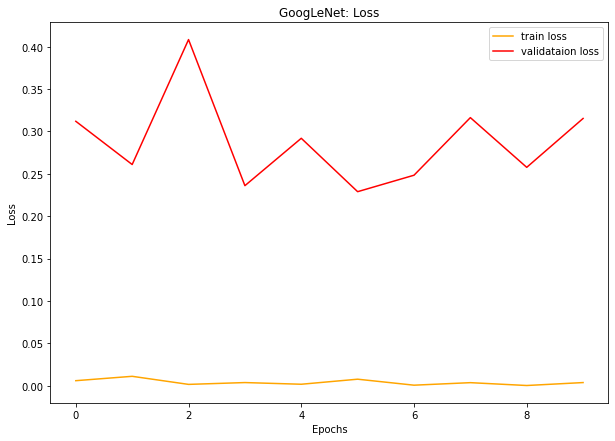

In [12]:
# loss
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.title('GoogLeNet: Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend()
plt.show()

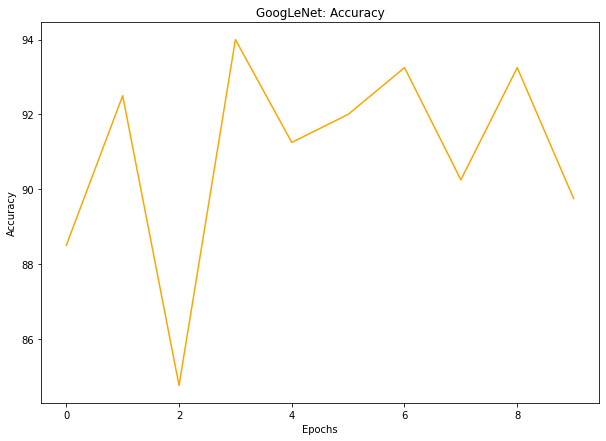

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(acc, color='orange', label='train accuracy')
plt.title('GoogLeNet: Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.show()

## 3. Evaluation

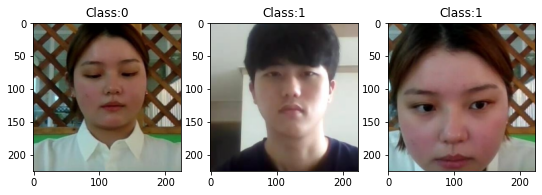

In [17]:
X, y = iter(test_loader).next()
X = X.to(DEVICE); y = y.to(DEVICE)

plt.figure(figsize=(3 * 3, 3))

for i in range(3):
  plt.subplot(1, 3, i+1)
  img = X[i].permute(1, 2, 0).detach().cpu()
  img = np.array(img, dtype=np.float32) 
  plt.imshow(img)
  plt.title('Class:' + str(y[i].detach().cpu().item()))

In [18]:
with torch.no_grad():
  pred = googlenet(X)

print(torch.round(torch.sigmoid(pred[:3])).detach().cpu().squeeze())

tensor([0., 0., 1.])
